In [1]:
from scmodels import SCM
import random, math

In [2]:
def get_distributions():
    ep = .1
    dists = [
        f"LogLogistic(alpha={random.randint(5, 20)}, beta={round(random.uniform(1,3.5),1)})",
        f"Normal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"LogNormal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"Benini(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)}, sigma={round(random.random() + ep, 1)})",
        f"Beta(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)})",
        f"Exponential(rate={round((random.random() + ep) * 10, 1)})",
        f"FDistribution(d1={random.randint(2, 4)}, d2={random.randint(5, 8)})",
        f"Gamma(k={round((random.random() + ep) * 4, 1)}, theta={round((random.random() + ep) * 8, 1)})",
        f"GammaInverse(a={round((random.random() + ep) * 4, 1)}, b={round((random.random() + ep) * 8, 1)})",
        f"Bernoulli({round(random.random(), 1)})",
        f"Binomial(n={random.randint(2, 10)}, p={round(random.random(), 1)}, succ={random.randint(3, 20)}, fail={random.randint(3, 20)})",
        f"BetaBinomial(n={random.randint(10, 100)}, alpha={round(random.random() + ep, 1)}, beta={round(random.uniform(2, 5),1)})",
        f"Die(sides={random.randint(4, 10)})",
        f"DiscreteUniform(items='1 2 3')",
        f"Geometric(p={round(random.random(), 2)})",
        f"Poisson(lamda={round(random.random() + ep, 1)})",
        f"FiniteRV({{{random.randint(5, 10)}: 1/2, {random.randint(0, 3)}: 1/6, {random.randint(15, 25)}: 1/6, {random.randint(30, 50)}: 1/6}})"
    ]
    
    return dists

In [26]:
def add_noise(dist):
    noise_ops = [False, True]
    op = random.choices(noise_ops, weights=(5, 1), k=1)[0]
    if op:
        dist = f"( {dist} ) * N"
    
    return dist

In [27]:
def add_complex_operation(dist):
    complex_ops = [False, "sqrt", "**2"]
    op = random.choices(complex_ops, weights=(10, 1, 1), k=1)[0]
    if op:
        if "*" in op:
            dist = f"( {dist} ){op}"
        else:
            dist = f"{op} ( {dist} )"
    
    return dist

In [28]:
def create_simple_operation(dist, parent):
    simple_ops = ["+", "*", "()"]
    op_1 = random.choices(simple_ops, weights=(4, 4, 1), k= 1)[0]
    if op_1 == "()":
        op_2 = random.choices(simple_ops, weights=(1, 1, 0), k= 1)[0]
        dist = f"{op_1[0]} {dist} {op_2} {parent} {op_1[1]}"
    else:
        dist = f"{dist} {op_1} {parent}"
    
    return dist

In [29]:
def get_child_distribution(parents):
    dist = f"{parents[0]}"
    count = 0
    for p in parents[1:]:
        dist = create_simple_operation(dist, p)
        count += 1
        
        if count > 2:
            dist = add_complex_operation(dist)
            count = 0
        
        dist = add_noise(dist)
    
    dist = f"{dist} * N"
    return dist

In [30]:
def get_parents(levels_and_distributions):
    parent_levels = random.randint(1,len(levels_and_distributions))
    parents = []
    for level in range(parent_levels):
        possible_parents = levels_and_distributions[level][1]
        num_parents = random.randint(1, len(possible_parents))
        parents.extend(random.sample(possible_parents, num_parents))
    
    return parents

In [31]:
def populate_level_distributions(level, level_data, levels_and_distributions):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        
        if level == 0:
            dist = "N"
        else:
            dist = get_child_distribution(get_parents(levels_and_distributions))
            
        dist = f"{name} = {dist}, N ~ {random.sample(get_distributions(), 1)[0]}"
        level_dists.append(dist)
        dist_names.append(name)
    
    levels_and_distributions[level] = (level_dists, dist_names)

In [32]:
def create_scm(level_name_numnodes):
    levels_and_distributions = {}
    for level, level_data in level_name_numnodes.items():
        populate_level_distributions(level, level_data, levels_and_distributions)

    scm_dists = []
    for n in range(len(levels_and_distributions)):
        scm_dists.extend(levels_and_distributions[n][0])
    
    scm = SCM(
        scm_dists
    )
    
    return scm

In [33]:
def create_names_and_num_nodes_dict(nodes_per_level, level_names):
    level_name_numnodes = {}
    for n, name in enumerate(level_names):
        level_name_numnodes[n] = {'name': name, 'num': nodes_per_level[n]}
        
    return level_name_numnodes

In [34]:
def get_level_names(numnodes_per_level):
    level_names = []
    for n in range(len(numnodes_per_level)):
        level_names.append(chr(65 + n))
    
    return level_names

In [35]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_list)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_list, level_names)
    
    scm = create_scm(level_name_numnodes)
    return scm

In [36]:
def get_numnodes_per_level(input_nodes):
    nodes = input_nodes
    levels = int(math.pow(nodes, 1/3))
    numnodes_per_level = []
    for n in range(levels):
        ub = round(math.log(nodes)) - 0.6
        lb = ub - 0.7
        level_nodes = int(math.exp(round(random.uniform(lb,ub), 1)))
        if level_nodes == 0 : break

        numnodes_per_level.append(level_nodes)
        nodes -= level_nodes
        
    return numnodes_per_level

In [37]:
def create_scm_from_num_nodes(input_nodes):
    nodes_list = get_numnodes_per_level(input_nodes)
    scm = create_scm_from_nodes_list(nodes_list)
    return scm

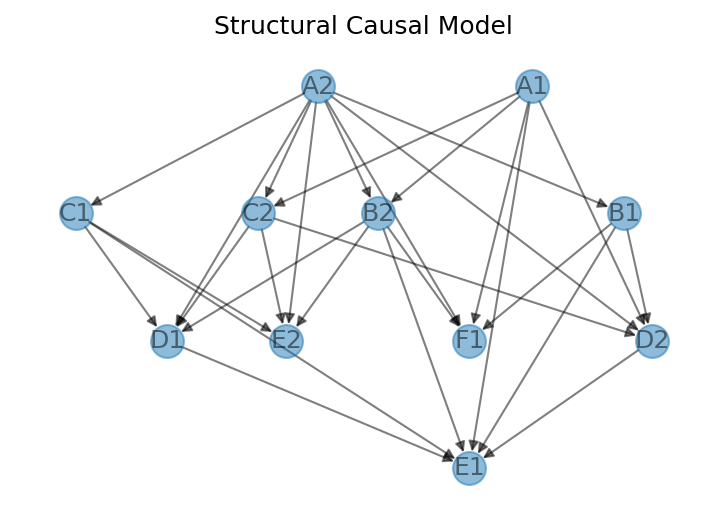

In [38]:
input_nodes = [2,2,2,2,2,1]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [39]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,B1,B2,C1,C2,F1,D1,D2,E2,E1
0,6.0,2.0,14.218535,36.0,0.288003,108.0,6.998576e+06,38.288003,1.842722e+04,224.625977,1.013088e+09
1,1.0,1.0,0.180943,2.0,0.931330,1.0,5.269157e+04,6.931330,1.809428e-01,3.931330,1.660722e+02
2,2.0,2.0,0.424214,12.0,1.161275,16.0,1.850977e+04,527.161275,2.714968e+01,32.580397,3.952256e+06
3,5.0,1.0,0.926179,15.0,0.090690,45.0,5.977171e+05,1636.090690,1.667123e+03,20.081041,4.197764e+08
4,1.0,2.0,2.882940,6.0,0.006831,8.0,2.543646e+06,40.006831,4.612704e+01,8.054646,7.670781e+04
...,...,...,...,...,...,...,...,...,...,...,...
95,6.0,3.0,56.515609,18.0,0.698977,162.0,4.829568e+07,21.698977,4.449587e+06,247.468654,2.484946e+11
96,3.0,2.0,4.007243,18.0,1.552583,6.0,1.287908e+08,141.552583,3.895040e+03,57.261983,5.730517e+08
97,6.0,2.0,5.033820,36.0,1.822209,108.0,2.945204e+09,39.822209,6.523830e+03,1218.791655,5.641794e+08
98,5.0,1.0,12.988271,5.0,0.193570,5.0,2.390562e+07,116.193570,2.597654e+03,13.742814,1.305770e+08


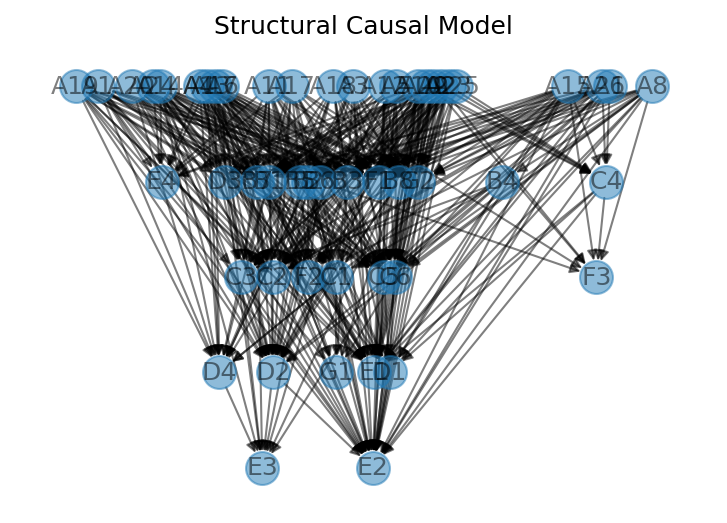

In [40]:
input_nodes = [25, 8, 6, 4, 4, 3, 2]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [41]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,C3,F2,F3,E1,D1,G1,D2,D4,E2,E3
0,55.0,14.896398,1.738361,1.0,2.0,7.0,1.018196,1.0,3.190445,3.790913,...,5.531966e+29,1.492929e+22,3.550486e+05,4.156362e+15,1.616624e+26,8.585678e+22,6.775814e+52,1.589472e+61,4.496881e+52,0.0
1,75.0,22.277140,2.872495,5.0,1.0,0.0,2.278742,4.0,1.331177,6.110287,...,2.523705e+17,1.676010e+13,3.313345e+05,1.379152e+05,9.133966e+22,1.841005e+21,2.195802e+35,1.358915e+44,1.162180e+35,0.0
2,75.0,17.088274,1.066752,5.0,2.0,3.0,2.206188,4.0,1.399154,2.321124,...,3.011423e+30,4.367680e+18,1.462029e+04,3.408280e+17,2.704051e+28,3.895036e+29,5.754812e+51,3.235500e+58,7.031247e+51,0.0
3,75.0,8.113177,1.463365,2.0,2.0,9.0,2.173234,10.0,4.690965,2.846393,...,8.512406e+18,5.690302e+06,3.342288e+07,1.738184e+16,4.572751e+18,8.065744e+23,2.394403e+34,1.072411e+35,2.494887e+34,0.0
4,55.0,3.373764,0.761624,3.0,1.0,14.0,3.300037,4.0,23.326254,0.742667,...,2.101187e+18,7.640232e+09,6.718037e+03,3.226606e+11,5.193944e+22,1.661417e+19,8.630102e+37,6.044157e+42,1.782639e+37,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,75.0,8.169689,0.287695,4.0,1.0,2.0,1.588231,0.0,45.271881,1.537550,...,2.172417e+17,1.218659e+08,1.146952e+06,7.333132e+09,7.472104e+13,8.970974e+18,4.839429e+28,8.592454e+44,1.038586e+28,0.0
96,75.0,12.749525,1.937367,6.0,2.0,13.0,1.166947,0.0,5.460953,2.317944,...,0.000000e+00,4.403007e+09,1.054441e+04,1.560437e+06,2.589592e+09,6.443539e+18,2.302702e+08,3.468883e+03,3.680639e+25,0.0
97,85.0,12.672080,0.671443,2.0,1.0,23.0,1.858516,2.0,8.047599,1.668247,...,4.067018e+20,4.830800e+12,2.467988e+07,2.071740e+14,1.112610e+35,3.142450e+25,4.370691e+37,2.186052e+55,2.307117e+37,0.0
98,75.0,10.066040,0.508576,3.0,3.0,3.0,9.577224,0.0,44.111046,2.676064,...,1.395881e+28,5.059848e+13,9.904313e+03,5.318740e+14,1.125248e+16,4.835957e+22,8.721925e+48,1.536667e+57,1.015666e+49,0.0


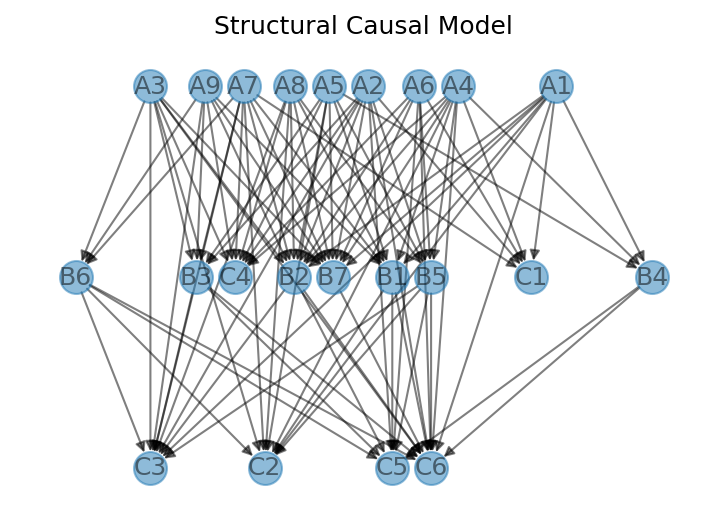

In [42]:
input_nodes = 30
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [43]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float
<lambdifygenerated-471>:2: RuntimeWarning: invalid value encountered in sqrt
  return (A1*A4*A6*A9*sqrt(A2*A3*A5*A7) + A8)*N**2


,A1,A2,A3,A4,A5,A6,A7,A8,A9,B4,...,B1,B2,B3,B6,B7,C4,C2,C3,C5,C6
0,40.0,41.558529,0.306216,33.0,0.0,7.0,12.0,0.171207,0.0,292.0,...,0.000000,16.232406,502.376944,12.918649,1.355766,16.667596,10418.077788,0.000000e+00,1.425839e+08,5.423063e+00
1,6.0,8.432725,0.122968,33.0,1.0,5.0,3.0,0.968920,0.0,640.0,...,1129.660579,8255.570498,25.667080,3.983747,15.715114,11.836566,2189.386805,2.399819e+07,-3.759999e+07,2.953718e+07
2,6.0,30.491977,0.732074,33.0,0.0,0.0,6.0,0.437689,0.0,624.0,...,0.000000,28.074299,187.344306,11.856591,1.173224,1460.270498,8107.469393,0.000000e+00,8.880196e+05,7.039344e+00
3,40.0,-6.837050,0.093850,28.0,0.0,1.0,1.0,0.357445,0.0,612.0,...,0.000000,0.000000,-6.743200,1.750799,1.526887,0.721877,2297.044962,0.000000e+00,-1.082861e+04,6.107549e+00
4,40.0,26.213520,0.601900,33.0,0.0,4.0,1.0,0.000001,0.0,1168.0,...,0.000000,4.213311,26.815421,4.611403,0.000005,0.000023,1544.624926,0.000000e+00,6.719566e+06,9.054513e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.0,-13.978139,1.528880,33.0,0.0,4.0,4.0,0.027703,0.0,624.0,...,0.000000,7.782915,-49.797038,10.115520,0.040330,56.566934,14923.984915,0.000000e+00,-9.973179e+06,4.033021e-02
96,40.0,5.058430,0.114649,33.0,0.0,3.0,5.0,0.000270,1.0,1168.0,...,0.000000,3964.596775,30.865394,6.343947,0.004242,0.225953,11172.892315,0.000000e+00,1.820982e+05,1.272585e-02
97,0.0,65.228492,0.224825,38.0,0.0,1.0,5.0,0.084673,0.0,38.0,...,0.000000,8.975438,327.266588,6.124127,7.647883,43.812014,1805.516654,0.000000e+00,3.191302e+05,1.529577e+01
98,6.0,15.408203,0.042880,33.0,0.0,3.0,15.0,0.042405,0.0,1404.0,...,0.000000,0.767565,231.766242,15.214402,0.110862,0.302911,31940.617669,0.000000e+00,1.184606e+07,4.434497e-01
